# Using LSTM to predict the Tokyo Stock Exchange variations

One of the first exercise we are proposed to do with Long Short Term Memory models is to try to predict the stock exchange variations.

When we look at the graphs produced by these models, it's quite impressive to see the Training and Test line hug the real price so close, but how good are these predictions?

Hypothesis:
* We only try to predict the next day, because more than that, any model just have no clue where things are going, and the accumulation of unknown just makes it even less reliable. So day traiding scenario only.
* Because values are normalized in order to train the model, the prediction will also be normalized, which means that it will not give a price. We could try to convert the value back to a real value, but is it really necessary? If the objective is just to guess which stock will go up, and how confident we are that it will go up, just a general indication (up/down) could be sufficient.

With these hypothesis, I tried to train a model that would look at the past values, and try to guess which stock should be purchased tomorrow morning, because it should be going up during the day.

## Conclusion

See at the end.

## Spoilers

It's quite unreliable. I wouldn't use this to blindly chose my investments.

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
# import seaborn
import json
from datetime import date
import datetime
import random
import time
from os import path
import pandas as pd
import numpy as np
from scipy.stats import beta
from math import sqrt

import requests

# from pandas_datareader import data as dr

from html.parser import HTMLParser
from html.entities import name2codepoint

# pip install opencv-python matplotlib numpy scipy keras scikit-learn tensorflow

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

np.random.seed(42)

# pip install yfinance
import yfinance as yf

%matplotlib inline

# %load_ext autoreload
# %autoreload 2


Using TensorFlow backend.


# Load/Update of the list of symbols from Nikkei 225 site

This next cell checks if there is a nikkei225.json file in the current folder and loads it. If there isn't one, it will go recover the latest list on the official nikkei site. 

(Source of the Nikkei 225 companies: https://indexes.nikkei.co.jp/en/nkave/index/component?idx=nk225. There is a screw up on their site for Osaka Gas, and I am too lazy to fix it in the code. There is one company that doesn't display well, and it's that one.)

In [2]:
nfile = 'nikkei225.json'

class MyHTMLParser(HTMLParser):    
    def handle_starttag(self, tag, attrs):
        global dept, nikkei225, area, company, location
        
        dept += 1
        for attr in attrs:
            if attr[0] == 'class':
                if attr[1] == 'col-xs-11 col-sm-11' and dept == 8:
                    location = 0
                    company = {
                        'code': "",
                        'url': "",
                        'name': "",
                        'area': ""
                    }
                elif attr[1] == 'col-xs-3 col-sm-1_5' and dept == 8:
                    location = 1
            elif attr[0] == 'href' and location == 2:
                company['url'] = attr[1]
                location = 3

    def handle_endtag(self, tag):
        global dept
        dept -= 1

    def handle_data(self, data):
        global dept, nikkei225, area, company, location
        if location == 0 and dept == 8:
            print("Area:", data)
            company["area"] = data
            location = None
        elif location == 1 and dept == 8 and data not in ['Code', 'Company Name']:
            company['code'] = data + ".T"
            location = 2
        elif location == 3 and dept == 8:
            company['name'] = data
            nikkei225[company['code']] = dict(company)                

            
if path.exists(nfile):
    if (time.time() - path.getmtime(nfile) < (7 * 24 * 60 * 60)): # Update the list every week
        print('the current {} file is good enough'.format(nfile))
        with open(nfile, 'r') as infile:
            nikkei225 = json.load(infile)
    else:
        print('the current {} file is too old'.format(nfile))
        nikkei225 = {}
        
if len(nikkei225.keys()) == 0:
    nikkei225 = {}
    company = {}
    area = ""
    dept = 0
    location = None
    
    r = requests.get('https://indexes.nikkei.co.jp/en/nkave/index/component?idx=nk225')
    print('http get status', r.status_code, 'length', len(r.text))
    parser = MyHTMLParser()
    parser.feed(r.text)
    
    with open(nfile, 'w') as outfile:
        json.dump(nikkei225, outfile)

print('Number of symbols in the Nikkei 225 index: {}'.format(len(nikkei225.keys())))

the current nikkei225.json file is too old
http get status 200 length 76143
Area: Pharmaceuticals
Area: Electric Machinery
Area: Automobiles & Auto parts
Area: Precision Instruments
Area: Communications
Area: Banking
Area: Other Financial Services
Area: Securities
Area: Insurance
Area: Fishery
Area: Foods
Area: Retail
Area: Services
Area: Mining
Area: Textiles & Apparel
Area: Pulp & Paper
Area: Chemicals
Area: Petroleum
Area: Rubber
Area: Glass & Ceramics
Area: Steel
Area: Nonferrous Metals
Area: Trading Companies
Area: Construction
Area: Machinery
Area: Shipbuilding
Area: Other Manufacturing
Area: Real Estate
Area: Railway & Bus
Area: Land Transport
Area: Marine Transport
Area: Air Transport
Area: Warehousing
Area: Electric Power
Area: Gas
Number of symbols in the Nikkei 225 index: 225


# Download the current symbol values from the Yahoo Finance Site

In [258]:
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
print('today', today.strftime("%Y-%m-%d"), 'tomorrow', tomorrow.strftime("%Y-%m-%d"))

tickers = list(nikkei225.keys()) + ['^N225']
start_date = '2018-01-01'
end_date = tomorrow

all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

today 2020-05-16 tomorrow 2020-05-17


In [228]:
# Downloading the values from Yahoo Finance here
df_raw_nikkei225 = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  226 of 226 completed


In [259]:
# A bit of cleanup...
df_clean_nikkei225 = df_raw_nikkei225.reindex(all_weekdays)
df_clean_nikkei225 = df_clean_nikkei225.fillna(method='ffill')

df_clean_nikkei225

Adj Close                                                      \
                1332.T       1333.T       1605.T       1721.T       1801.T   
2018-01-01  569.744080  3270.879639  1344.925293  3092.923340  5212.154297   
2018-01-02  569.744080  3270.879639  1344.925293  3092.923340  5212.154297   
2018-01-03  569.744080  3270.879639  1344.925293  3092.923340  5212.154297   
2018-01-04  570.711304  3285.310059  1391.219727  3178.179688  5323.644043   
2018-01-05  570.711304  3285.310059  1381.674561  3154.497314  5370.098145   
...                ...          ...          ...          ...          ...   
2020-05-11  479.000000  2317.000000   697.000000  2992.000000  3535.000000   
2020-05-12  476.000000  2319.000000   690.299988  2966.000000  3520.000000   
2020-05-13  473.000000  2307.000000   682.799988  3010.000000  3475.000000   
2020-05-14  462.000000  2305.000000   663.400024  3005.000000  3485.000000   
2020-05-15  446.000000  2171.000000   682.000000  3020.000000  3530.000000   

                                                                             \
                 1802.T       1803.T       1808.T       1812.T       1925.T   
2018-01-01  1269.765381  1109.852905  1591.134033  2022.888062  3972.852539   
2018-01-02  1269.765381  1109.852905  1591.134033  2022.888062  3972.852539   
2018-01-03  1269.765381  1109.852905  1591.134033  2022.888062  3972.852539   
2018-01-04  1294.899902  1133.689819  1622.938477  2069.541260  4092.212402   
2018-01-05  1299.554565  1134.643433  1646.564697  2067.675293  4145.465332   
...                 ...          ...          ...          ...          ...   
2020-05-11   952.000000   875.000000  1208.000000  1167.000000  2778.500000   
2020-05-12   946.000000   864.000000  1195.000000  1160.000000  2731.500000   
2020-05-13   940.000000   860.000000  1194.000000  1145.000000  2744.000000   
2020-05-14   918.000000   846.000000  1157.000000  1144.000000  2450.500000   
2020-05-15   910.000000   845.000000  1150.000000  1185.000000  2390.000000   

            ...     Volume                                             \
            ...     9503.T     9531.T     9532.T    9602.T     9613.T   
2018-01-01  ...        0.0        0.0        0.0       0.0        0.0   
2018-01-02  ...        0.0        0.0        0.0       0.0        0.0   
2018-01-03  ...        0.0        0.0        0.0       0.0        0.0   
2018-01-04  ...  2487200.0  1849200.0  1646900.0  643400.0  4249800.0   
2018-01-05  ...  1917400.0  1979200.0  1524300.0  254900.0  3359400.0   
...         ...        ...        ...        ...       ...        ...   
2020-05-11  ...  2343500.0  1093400.0  1066300.0  410800.0  4610500.0   
2020-05-12  ...  1991200.0   900100.0  1543500.0  330200.0  3603000.0   
2020-05-13  ...  4470700.0  1030700.0  1377200.0  393400.0  3617900.0   
2020-05-14  ...  3607100.0   817200.0   987400.0  329200.0  4056100.0   
2020-05-15  ...  2441600.0   927000.0   832200.0  350000.0  6569400.0   

                                                                  
              9735.T     9766.T     9983.T      9984.T     ^N225  
2018-01-01       0.0        0.0        0.0         0.0       NaN  
2018-01-02       0.0        0.0        0.0         0.0       NaN  
2018-01-03       0.0        0.0        0.0         0.0       NaN  
2018-01-04  800000.0   797600.0   997900.0  17888400.0  102200.0  
2018-01-05  685200.0   494200.0   731100.0  11306200.0  101900.0  
...              ...        ...        ...         ...       ...  
2020-05-11  373400.0   677000.0  1189900.0  11934200.0   76200.0  
2020-05-12  524800.0   436900.0  1042600.0  12076700.0   67700.0  
2020-05-13  777500.0   653200.0  1193300.0  18234300.0   79500.0  
2020-05-14  669400.0   780100.0   755200.0  17091200.0   76900.0  
2020-05-15  512700.0  1211800.0  1000200.0  16681100.0   75200.0  

[620 rows x 1356 columns]

In [260]:
# keeping a dataframe with just the close values
df_close_nikkei225 = df_clean_nikkei225['Close']

# here I am adding few values, mainly rolling averages over 5,20 and 100 days, 
# then the ratio between the 5 and 20 days rolling average, then 20 and 100 days
for symbol in [x for x in nikkei225.keys()]:
    df_clean_nikkei225[('RollAvg5', symbol)] = df_close_nikkei225.loc[:, symbol].rolling(window=5).mean()
    df_clean_nikkei225[('RollAvg20', symbol)] = df_close_nikkei225.loc[:, symbol].rolling(window=20).mean()
    df_clean_nikkei225[('RollAvg100', symbol)] = df_close_nikkei225.loc[:, symbol].rolling(window=100).mean()
    df_clean_nikkei225[('N225', symbol)] = df_close_nikkei225.loc[:, '^N225']
    
    df_clean_nikkei225[('ratio5-20', symbol)] = df_clean_nikkei225[('RollAvg5', symbol)] / df_clean_nikkei225[('RollAvg20', symbol)]
    df_clean_nikkei225[('ratio20-100', symbol)] = df_clean_nikkei225[('RollAvg20', symbol)] / df_clean_nikkei225[('RollAvg100', symbol)]
    
    
# keeping a dataframe with the relevant values used for our model
df_relev_nikkei225 = df_clean_nikkei225[['Close', 'High', 'Low', 'Volume', 'RollAvg5', 'RollAvg20', 'RollAvg100', 'ratio5-20', 'ratio20-100', 'N225']]
df_relev_nikkei225.tail(-100)

Close                                                       \
           1332.T  1333.T       1605.T  1721.T  1801.T  1802.T  1803.T   
2018-05-21  570.0  4125.0  1378.500000  2921.0  6130.0  1161.0  1109.0   
2018-05-22  571.0  4065.0  1364.000000  2904.0  6140.0  1154.0  1106.0   
2018-05-23  562.0  4060.0  1302.500000  2891.0  6050.0  1142.0  1099.0   
2018-05-24  551.0  4110.0  1284.500000  2915.0  6060.0  1119.0  1087.0   
2018-05-25  547.0  4090.0  1248.500000  2929.0  6040.0  1136.0  1085.0   
...           ...     ...          ...     ...     ...     ...     ...   
2020-05-11  479.0  2317.0   697.000000  2992.0  3535.0   952.0   875.0   
2020-05-12  476.0  2319.0   690.299988  2966.0  3520.0   946.0   864.0   
2020-05-13  473.0  2307.0   682.799988  3010.0  3475.0   940.0   860.0   
2020-05-14  462.0  2305.0   663.400024  3005.0  3485.0   918.0   846.0   
2020-05-15  446.0  2171.0   682.000000  3020.0  3530.0   910.0   845.0   

                                    ...          N225                \
            1808.T  1812.T  1925.T  ...        9101.T        9104.T   
2018-05-21  1660.0  1822.0  4205.0  ...  23002.369141  23002.369141   
2018-05-22  1661.0  1834.0  4184.0  ...  22960.339844  22960.339844   
2018-05-23  1642.0  1842.0  4109.0  ...  22689.740234  22689.740234   
2018-05-24  1625.0  1818.0  4034.0  ...  22437.009766  22437.009766   
2018-05-25  1649.0  1828.0  4029.0  ...  22450.789062  22450.789062   
...            ...     ...     ...  ...           ...           ...   
2020-05-11  1208.0  1167.0  2778.5  ...  20390.660156  20390.660156   
2020-05-12  1195.0  1160.0  2731.5  ...  20366.480469  20366.480469   
2020-05-13  1194.0  1145.0  2744.0  ...  20267.050781  20267.050781   
2020-05-14  1157.0  1144.0  2450.5  ...  19914.779297  19914.779297   
2020-05-15  1150.0  1185.0  2390.0  ...  20037.470703  20037.470703   

                                                                    \
                  9107.T        9202.T        9301.T        9501.T   
2018-05-21  23002.369141  23002.369141  23002.369141  23002.369141   
2018-05-22  22960.339844  22960.339844  22960.339844  22960.339844   
2018-05-23  22689.740234  22689.740234  22689.740234  22689.740234   
2018-05-24  22437.009766  22437.009766  22437.009766  22437.009766   
2018-05-25  22450.789062  22450.789062  22450.789062  22450.789062   
...                  ...           ...           ...           ...   
2020-05-11  20390.660156  20390.660156  20390.660156  20390.660156   
2020-05-12  20366.480469  20366.480469  20366.480469  20366.480469   
2020-05-13  20267.050781  20267.050781  20267.050781  20267.050781   
2020-05-14  19914.779297  19914.779297  19914.779297  19914.779297   
2020-05-15  20037.470703  20037.470703  20037.470703  20037.470703   

                                                                    
                  9502.T        9503.T        9531.T        9532.T  
2018-05-21  23002.369141  23002.369141  23002.369141  23002.369141  
2018-05-22  22960.339844  22960.339844  22960.339844  22960.339844  
2018-05-23  22689.740234  22689.740234  22689.740234  22689.740234  
2018-05-24  22437.009766  22437.009766  22437.009766  22437.009766  
2018-05-25  22450.789062  22450.789062  22450.789062  22450.789062  
...                  ...           ...           ...           ...  
2020-05-11  20390.660156  20390.660156  20390.660156  20390.660156  
2020-05-12  20366.480469  20366.480469  20366.480469  20366.480469  
2020-05-13  20267.050781  20267.050781  20267.050781  20267.050781  
2020-05-14  19914.779297  19914.779297  19914.779297  19914.779297  
2020-05-15  20037.470703  20037.470703  20037.470703  20037.470703  

[520 rows x 2254 columns]

## Graphing a single symbol with rolling averages (5, 20, 50 days)

4755.T


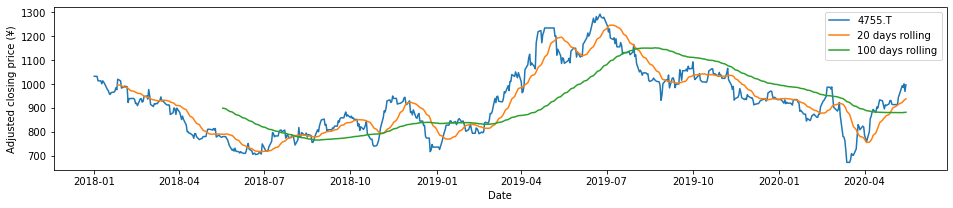

In [261]:
## This cell is just for testing. it will graph a symbol after recalculating rolling averages
# The graph_symbol function is also used later on.

def graph_symbol(symbol, df):
    print(symbol)
    # Get the timeseries. This now returns a Pandas Series object indexed by date.

    wtv = df.loc[:, symbol]

    roll_20_days = wtv.rolling(window=20).mean()
    roll_100_days = wtv.rolling(window=100).mean()

    # Plot everything
    fig, ax = plt.subplots(figsize=(16,3))

    ax.plot(wtv.index, wtv, label=symbol)
    ax.plot(roll_20_days.index, roll_20_days, label='20 days rolling')
    ax.plot(roll_100_days.index, roll_100_days, label='100 days rolling')

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price (¥)')
    ax.legend()
    plt.show()

graph_symbol('4755.T', df_close_nikkei225)

## Defining the model

The next cell defines the function that will return a LSTN RNN.

In [8]:
# LSTM Related functions

def build_part1_RNN(window_size, n_features = 1, nodes = 5, dropout=0.2):
    model = Sequential()
    model.add(LSTM(nodes, activation='tanh', input_shape=(window_size, n_features), dropout=dropout))
    model.add(Dense(1))
    
    # build model using keras documentation recommended optimizer initialization
    optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

    # compile the model
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    # model.compile(loss='mae', optimizer='adam')
        
    return model

## Preparing the data to train the model

The `window_transform_3d_series` function returns the series days (X) and the value that need to be predicted (y)

In [262]:
# convert series to supervised learning
def window_transform_3D_series(df_X, df_y, window_size):
    # containers for input/output pairs
    X = []
    y = []
    #print('X', df_X.iloc[0:window_size].values)
    #print('y', df_y.iloc[window_size])
    
    for ii in range(len(df_X) - (window_size)):
        X.append(list(df_X.iloc[ii:ii+window_size].values))
        y.append(df_y.iloc[ii+window_size])

    # reshape each
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:3])
    y = np.asarray(y)
    y.shape = (len(y),1)
    

    return X, y

def mean_beta(a, b):
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
    return mean

if False: #testing function, just to confirm that the values are properly returned by window_transform_3D_series
    window_size = 8
    features = ['Close']
    objective='Close'
    n_features = len(features)

    for symbol in list(df_close_nikkei225.keys())[:1]:
        print(symbol)
        df_X = df_relev_nikkei225.loc[:, [(x, symbol) for x in features]]
        df_y = df_relev_nikkei225.loc[:, (objective, symbol)]

        df_X_scaled=((df_X-df_X.mean())/df_X.std())
        df_y_scaled=((df_y-df_y.mean())/df_y.std())

        X,y = window_transform_3D_series(df_X_scaled.fillna(0), df_y_scaled.fillna(0), window_size)

## Initializing the model

In [263]:
def training(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, epochs, batch_size, verbose=True):
    n_features = len(features)
    
    # if set to True, training will be done on all the nikkei225 companies. However, not all companies behave 
    # the same way while I coded this, most probably because of the pandemic. 
    # Because of the virus and the potential for high profit through speculations,
    # I decided to focus the model on pharmaceutical area companies
    
    if False:
        array = [x for x in nikkei225.keys()]
    else:
        array = [x for x in nikkei225.keys() if nikkei225[x]['area'] in areas]
        
    np.random.shuffle(array)
    
    for s in range(len(array)):
        symbol = array[s]
        df_X = df_relev_nikkei225.loc[:, [(x, symbol) for x in features]]
        df_y = df_relev_nikkei225.loc[:, (objective, symbol)]

        df_X_scaled=(df_X-df_X.mean())/df_X.std()
        df_y_scaled=(df_y-df_y.mean())/df_y.std()

        X,y = window_transform_3D_series(df_X_scaled.fillna(0), df_y_scaled.fillna(0), window_size)

        train_test_split = int(np.ceil(4*len(y)/float(5)))   # set the split point

        X_train = X[:train_test_split,:]
        y_train = y[:train_test_split]

        # keep the last chunk for testing
        X_test = X[train_test_split:,:]
        y_test = y[train_test_split:]

        # NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
        X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, n_features)))
        X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, n_features)))

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, shuffle=True)

        # generate predictions for training
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # print out training and testing errors
        training_error = model.evaluate(X_train, y_train, verbose=0)
        testing_error = model.evaluate(X_test, y_test, verbose=0)
        if verbose:
            print('* {} {} training error = {:0.3f} ({}), testing error: {:0.3f} ({})'.format(
                symbol, nikkei225[symbol]['name'], 
                training_error, training_error < error_objective, 
                testing_error, testing_error < error_objective
            ))


    if verbose:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=[20,15])
        plt.grid(True)
        plt.plot(df_X_scaled[objective].reset_index(drop=True),color = 'k')


        # plot training set prediction
        split_pt = train_test_split + window_size 
        plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

        # plot testing set prediction
        plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

        # pretty up graph
        plt.xlabel('day')
        plt.ylabel('(normalized) price of {} stock'.format(symbol))
        plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
    
    return model
        


# Training the model with the Nikkei225 values

Here we are defining the parameters of the model, then we initialize it and start the training.

> Note: The training function is hardcoded to focus only on pharmaceutical companies

* 2503.T KIRIN HOLDINGS CO., LTD. training error = 0.030 (False), testing error: 0.093 (False)
* 2501.T SAPPORO HOLDINGS LTD. training error = 0.021 (False), testing error: 0.243 (False)
* 9433.T KDDI CORP. training error = 0.026 (False), testing error: 0.222 (False)
* 9984.T SOFTBANK GROUP CORP. training error = 0.045 (False), testing error: 0.137 (False)
* 9613.T NTT DATA CORP. training error = 0.027 (False), testing error: 0.178 (False)
* 4151.T KYOWA KIRIN CO., LTD. training error = 0.028 (False), testing error: 0.387 (False)
* 4568.T DAIICHI SANKYO CO., LTD. training error = 0.010 (True), testing error: 0.083 (False)
* 4324.T DENTSU GROUP INC. training error = 0.010 (True), testing error: 0.222 (False)
* 4519.T CHUGAI PHARMACEUTICAL CO., LTD. training error = 0.006 (True), testing error: 0.349 (False)
* 4751.T CYBERAGENT, INC. training error = 0.029 (False), testing error: 0.036 (False)
* 4507.T SHIONOGI & CO., LTD. training error = 0.031 (False), testing error: 0.123 (False)
* 45

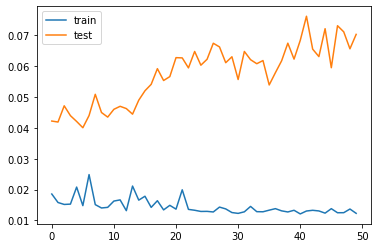

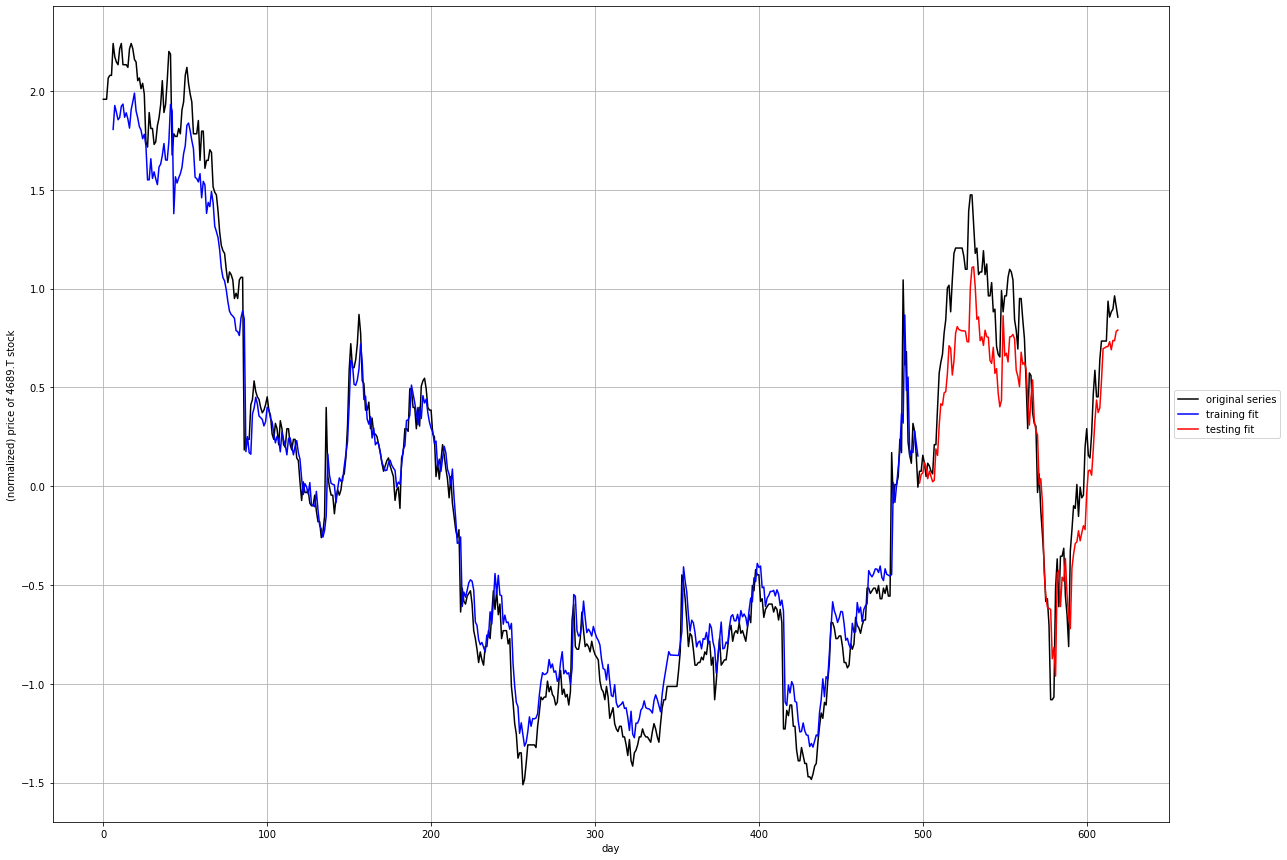

In [335]:
# {'mean': array(0.53284672), 'window_size': 5, 'epochs': 72, 'features': 'Close,Low,High,ratio5-20,ratio20-100,Volume', 'nodes': 16, 'batch_size': 51, 'dropout': 0.4157279059128228}

window_size = 6
features = [
    'Close',
    'Low',
    'High',
    #'RollAvg5', 
    #'RollAvg100',
    'ratio5-20',
    'ratio20-100',
    'Volume',
    'N225'
]
n_features = len(features)

objective='Close'

error_objective = 0.02

epochs = 50#50
batch_size = 50
nodes = 8#5 #window_size * 5
dropout = 0.1

model = build_part1_RNN(window_size, n_features, nodes, dropout)

areas = ['Pharmaceuticals', 'Communications', 'Foods', 'Services']

model = training(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, epochs, batch_size, True)

Wow! like all the LSTM examples, the prediction really look like the real values! I will be rich! ^_^

At the same time, humans are good to see patterns where there isn't any.

# Applying to predict the future

Now what? What can we do with this?

Let's say that we still take all the pharmaceutical companies listed in the Nikkei225, can we guess which ones will go up or down? How successful are the predictions? Can we trust them to help taking a decision about the next day's movements? 

This is what the following cell is doing. 
* It's going through all companies in the pharmaceutical area and rerun the training and testing values against the model. 
* While doing so, it will try to guess if the next day will go up or down, only on the test values, unused during the training.
* and if it goes up, does it goes up significantly enough in order to make profit? (+0.05 of the previously normalized value, this is arbitrary)
* For the one that does not qualify, we just forget about them. They can both be missed opportunities, or cases where value would really had declined.
* We then confirm if we did a good call to `buy` shares.
* At the last step, the code will display which symbol he thinks should be purchased, how many times the model was right (a)/wrong (b), and how much capital we would have if we had followed all the predictions, just for fun.

In [350]:
def strategy_predict_higher(predicted, last_prediction):
    decision = False
            
    if predicted < last_prediction:
        guess = 'Down'.format(predicted)
    else:
        guess = 'Up'.format(predicted)
        if predicted > last_prediction + (last_prediction * 0.1):
            decision = True
                    
    return decision, guess

def strategy_random(predicted, last_prediction):            
    if predicted < last_prediction:
        guess = 'Down'.format(predicted)
    else:
        guess = 'Up'.format(predicted)

    decision = random.randint(0,1)
    return decision, guess


def best_options(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, verbose=False):
    
    df_future = pd.DataFrame(columns = ['date', 'symbol', 'name', 'area', 'close', 'close_normalized', 'prediction', 'direction', 'buy', 'a', 'b', 'mean_beta', 'capital'])
    n_features = len(features)
    aa = 1
    bb = 1
    
    if len(areas) == 0:
        array = [x for x in nikkei225.keys()]
    else:
        array = [x for x in nikkei225.keys() if nikkei225[x]['area'] in areas]
        
    np.random.shuffle(array)
    
    for s in range(len(array)):
        symbol = array[s]
        
        df_X = df_relev_nikkei225.loc[:, [(x, symbol) for x in features]]
        df_y = df_relev_nikkei225.loc[:, (objective, symbol)]

        df_X_scaled=(df_X-df_X.mean())/df_X.std()
        df_y_scaled=(df_y-df_y.mean())/df_y.std()

        X,y = window_transform_3D_series(df_X_scaled.fillna(0), df_y_scaled.fillna(0), window_size)

        train_test_split = int(np.ceil(4*len(y)/float(5)))   # set the split point

        # keep the last chunk for testing
        X_test = X[train_test_split:,:]
        y_test = y[train_test_split:]

        # NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, n_features] 
        X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, n_features)))

        # generate predictions for training
        test_predict = model.predict(X_test)

        df_X_scaled_reindexed = df_X_scaled.reset_index()
        df_y_scaled_reindexed = df_y_scaled.reset_index()
        
#         df_X_reindexed = df_X.reset_index()
        df_y_reindexed = df_y.reset_index()
        
        last_prediction = 4

        a = 1
        b = 1
        capital = 0
    
        for t in range(len(y_test-1)):
#             print(len(df_X_scaled), train_test_split, len(X_test-1), t, window_size, train_test_split + t + window_size-1)
            
            scaled_sr = df_y_scaled_reindexed.iloc[train_test_split + t + window_size-1][['index', objective]]
            raw_sr = df_y_reindexed.iloc[train_test_split + t + window_size-1][['index', objective]]
            raw_tomorrow_sr = df_y_reindexed.iloc[train_test_split + t + window_size][['index', objective]]
            
            rday = str(raw_sr['index'].values[0]).split('T')[0]
            rtomorrow = str(raw_tomorrow_sr['index'].values[0]).split('T')[0]
            
            scaled_close = scaled_sr[(objective, symbol)]
            raw_close = raw_sr[(objective, symbol)]

            predicted = test_predict[t][0]
            
#             decision, guess = strategy_predict_higher(predicted, last_prediction)
            decision, guess = strategy_random(predicted, last_prediction)
            
            if len(y_test) > t+1:
                scaled_next = y_test[t]
                raw_next = raw_tomorrow_sr[(objective, symbol)]

                profit =  raw_next - raw_close

                if decision:
                    capital += profit
                    if profit > 0:
                        a+=1
                        aa+=1
                    if profit < 0:
                        b+=1
                        bb+=1

                    if False:
                        if profit > 0:
                            print(scaled_close, raw_close, predicted, guess, decision, profit)
                if not decision and False: # forgetting about the values that are predicted to go down
                    if profit < 0:
                        a+=1
                        aa+=1
                    if profit > 0:
                        b+=1
                        bb+=1
                    
                    
            else:
                item = {
                    'symbol': symbol,
                    'name': nikkei225[symbol]['name'],
                    'area': nikkei225[symbol]['area'],
                    'date': rday,
                    'close': raw_close,
                    'close_normalized': scaled_close, 
                    'prediction': predicted, 
                    'direction': guess, 
                    'buy': decision, 
                    'a': a, 
                    'b': b, 
                    'mean_beta': mean_beta(a,b),
                    'capital': capital
                }

                df_future = df_future.append(item, ignore_index=True)
                if item['buy']:
                    print("{} {} {} (buy: {}) capital: {}".format(item['symbol'], item['name'], item['area'], item['buy'], capital))

            last_prediction = predicted

    return mean_beta(aa,bb), df_future

In [351]:
mbeta, df_future = best_options(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, True)
print('mean_beta: ', mbeta)

2002.T NISSHIN SEIFUN GROUP INC. Foods (buy: 1) capital: 290.0
4507.T SHIONOGI & CO., LTD. Pharmaceuticals (buy: 1) capital: -930.0
2502.T ASAHI GROUP HOLDINGS, LTD. Foods (buy: 1) capital: -972.0
9412.T SKY PERFECT JSAT HOLDINGS INC. Communications (buy: 1) capital: -12.0
2801.T KIKKOMAN CORP. Foods (buy: 1) capital: 280.0
2531.T TAKARA HOLDINGS INC. Foods (buy: 1) capital: -264.0
4523.T EISAI CO., LTD. Pharmaceuticals (buy: 1) capital: -457.0
2432.T DENA CO., LTD. Services (buy: 1) capital: -296.0
2501.T SAPPORO HOLDINGS LTD. Foods (buy: 1) capital: -77.0
2269.T MEIJI HOLDINGS CO., LTD. Foods (buy: 1) capital: -550.0
9984.T SOFTBANK GROUP CORP. Communications (buy: 1) capital: 1033.0
4751.T CYBERAGENT, INC. Services (buy: 1) capital: 1065.0
4755.T RAKUTEN, INC. Services (buy: 1) capital: 6.0
4502.T TAKEDA PHARMACEUTICAL CO., LTD. Pharmaceuticals (buy: 1) capital: 187.5
4519.T CHUGAI PHARMACEUTICAL CO., LTD. Pharmaceuticals (buy: 1) capital: 496.0
2282.T NH FOODS LTD. Foods (buy: 1) c

That last mean_beta value is an important indicator. It means that the model and conditions was successful ~47.7% of the time with the current model and parameters. This seems to be less than a coin flip.

## According to our model, which stock is expected to rise tomorrow?

In [305]:
budget_limit = 2000 # maximum price willing to pay per share

df_future[(df_future['buy'] == True) & (df_future['close'] < budget_limit)].sort_values(['mean_beta'], ascending=False)

,date,symbol,name,area,close,close_normalized,prediction,direction,buy,a,b,mean_beta,capital


In this case, the model is telling us that we should not buy any share because it believes that one will be profitable enough.

In [306]:
# this cell graphes all the shares identified as potentials by the model.
for i, r in df_future[(df_future['buy'] == True) & (df_future['close'] < budget_limit)].sort_values(['mean_beta'], ascending=False).iterrows():
    graph_symbol(r['symbol'], df_close_nikkei225)

## How about the other stocks, what should happen to them?

Ok, the model is telling us that we should not buy anything, but does this mean that no share will be going up? Here, because I did set a maximum budget per share to 2000¥, anything that is more expensive will not be displayed.

The following cell is displaying all the shares that are predicted to go up, regardless of the budget, or the expectations of profits.

In [307]:
df_future[df_future['direction'] == 'Up'].sort_values(['mean_beta'], ascending=False).head(20)

,date,symbol,name,area,close,close_normalized,prediction,direction,buy,a,b,mean_beta,capital
1,2020-05-14,4502.T,"TAKEDA PHARMACEUTICAL CO., LTD.",Pharmaceuticals,4028.0,-0.519153,-0.285553,Up,True,64,47,0.5765765765765766,387.5
7,2020-05-14,4568.T,"DAIICHI SANKYO CO., LTD.",Pharmaceuticals,8489.0,2.194748,1.821278,Up,True,58,53,0.5225225225225225,1689.0
6,2020-05-14,4523.T,"EISAI CO., LTD.",Pharmaceuticals,7490.0,-0.164588,-0.258516,Up,True,57,54,0.5135135135135135,1312.0
2,2020-05-14,4503.T,ASTELLAS PHARMA INC.,Pharmaceuticals,1797.5,0.828593,0.608799,Up,False,47,64,0.42342342342342343,-321.0


### Descriptions of the columns

* date: current date
* symbol: symbol on the Tokyo Stock Exchange (nikkei)
* name: official company name
* area: The nikkei is grouped in multiple areas
* close: closing price
* close_normalized: all values are normalized, this is the value once normalized
* prediction: the model predict that the next close_normalized value should be of x (also normalized)
* direction: here we are comparing against the last prediction value, because often the close value and the prediction value aren't exactly the same
* buy: should we buy or not?
* a: this to calculate the mean beta distribution: a == successfully predicted the next day during training
* b: this to calculate the mean beta distribution: b == failed to predict the next day during training
* mean_beta: mean beta distribution, what is the percentage of success of the model at predicting the model for that symbol
* capital: this is just to toy around. starting with a capital of 0 on 2019-01-01, if we buy when the model tells to buy, how much yens would we have a the end?

## What is the current value of these shares that should be purchased?

I used this sell during my testing. I was doing the simulation the night before, then when it was passed 15:00 JST, I was running this cell to check the new values and see how rich I would have become.

In [212]:
now = datetime.date.today()
yesterday = now - datetime.timedelta(days=1)
tomorrow = now + datetime.timedelta(days=1)
print('yesterday', yesterday.strftime("%Y-%m-%d"), 'now', now.strftime("%Y-%m-%d"), 'tomorrow', tomorrow.strftime("%Y-%m-%d"))

focus_tickers = list(df_future[df_future['direction'] == 'Up']['symbol'].unique())
start_date = yesterday.strftime("%Y-%m-%d")
end_date = tomorrow.strftime("%Y-%m-%d")

# Downloading the values from Yahoo Finance here
df_raw_focus_nikkei225 = yf.download(focus_tickers, start=start_date, end=end_date)

# A bit of cleanup...
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
df_clean_focus_nikkei2225 = df_raw_focus_nikkei225.reindex(all_weekdays)
df_clean_focus_nikkei2225 = df_clean_focus_nikkei2225.fillna(method='ffill')

# keeping a dataframe with just the close values
df_clean_focus_nikkei2225['Close']

yesterday 2020-05-15 now 2020-05-16 tomorrow 2020-05-17
[*********************100%***********************]  4 of 4 completed


,4502.T,4503.T,4523.T,4568.T
2020-05-15,4012.0,1728.0,7454.0,8432.0


In the 4 symbols that were predicted to go up, 1 did... and 3 didn't.

# Conclusion

The predictions from the LSTM RNN seems to be following the reality, but if we try to use these predictions to take purchasing decisions, we can see that the results look like a coin toss. The number of successes VS failures are quite around 50%, which is consistant with a random guess.

Can we use this in real life? I wouldn't.

# Optimization section

This section is mainly to try multiple parameters over and over, attempting to find the best parameters for the model.

It is currently set not to run.

In [324]:
%%time 

def init_optimization(nikkei225, df_relev_nikkei225, areas, features, objective):
    df_mean_beta = pd.DataFrame(columns=['mean', 'window_size', 'epochs', 'features', 'nodes', 'dropout'])
    
    window_size_range = [3, 6]
    epochs_range = [30, 60]
    nodes_range = [5, 30]
    batch_size_range = [40, 75]
    dropout_range = [0.0, 0.2]
    n_features = len(features)
    
    max_tests = 10
    for r in range(max_tests):
        window_size = random.randint(window_size_range[0], window_size_range[1])
        epochs = np.random.randint(low=epochs_range[0], high=epochs_range[1])
        nodes = np.random.randint(low=nodes_range[0], high=nodes_range[1])
        dropout = np.random.uniform(low=dropout_range[0], high=dropout_range[1])
        batch_size = np.random.randint(low=batch_size_range[0], high=batch_size_range[1])

        print(r, window_size, epochs, features, nodes, dropout)
        
        model = build_part1_RNN(window_size, n_features, nodes, dropout)
        model = training(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, epochs, batch_size, False)
        
        mbeta, df_future = best_options(nikkei225, df_relev_nikkei225, areas, model, window_size, features, objective, False)
        
        run = {
            'mean': mbeta,
            'window_size': window_size,
            'epochs': epochs,
            'features': ",".join(features),
            'nodes': nodes,
            'batch_size': batch_size,
            'dropout': dropout
        }
        print(run)
        
        df_mean_beta = df_mean_beta.append(run, ignore_index=True)
    return df_mean_beta
    

if True:
    areas = ['Pharmaceuticals', 'Foods', 'Services']
    
    features = [
        'Close',
#         'Low',
#         'High',
#         'RollAvg5', 
#         'RollAvg100',
        'ratio5-20',
        'ratio20-100',
        'Volume',
        'N225'
    ]
    
    objective = 'Close'
    
    df_mean_beta = init_optimization(nikkei225, df_relev_nikkei225, areas, features, objective)
    
    

0 3 52 ['Close', 'ratio5-20', 'ratio20-100', 'Volume', 'N225'] 14 0.17835255261556443
2002.T NISSHIN SEIFUN GROUP INC. Foods (buy: True) capital: -62.0
4523.T EISAI CO., LTD. Pharmaceuticals (buy: True) capital: 693.0
2801.T KIKKOMAN CORP. Foods (buy: True) capital: -735.0
2269.T MEIJI HOLDINGS CO., LTD. Foods (buy: True) capital: -870.0
4502.T TAKEDA PHARMACEUTICAL CO., LTD. Pharmaceuticals (buy: True) capital: 245.0
2432.T DENA CO., LTD. Services (buy: True) capital: -109.0
4751.T CYBERAGENT, INC. Services (buy: True) capital: -260.0
{'mean': array(0.48857391), 'window_size': 3, 'epochs': 52, 'features': 'Close,ratio5-20,ratio20-100,Volume,N225', 'nodes': 14, 'batch_size': 69, 'dropout': 0.17835255261556443}
1 3 41 ['Close', 'ratio5-20', 'ratio20-100', 'Volume', 'N225'] 13 0.08673873713163888
2914.T JAPAN TOBACCO INC. Foods (buy: True) capital: -502.0
2801.T KIKKOMAN CORP. Foods (buy: True) capital: -685.0
2432.T DENA CO., LTD. Services (buy: True) capital: -167.0
4751.T CYBERAGENT, 

In [326]:
df_mean_beta.sort_values(by='mean', ascending=False)

,mean,window_size,epochs,features,nodes,dropout,batch_size
5,0.5047729245010124,4,31,"Close,ratio5-20,ratio20-100,Volume,N225",26,0.023008,60.0
3,0.5044836563494359,3,51,"Close,ratio5-20,ratio20-100,Volume,N225",9,0.118746,65.0
7,0.5041943881978594,5,51,"Close,ratio5-20,ratio20-100,Volume,N225",13,0.143641,47.0
9,0.5021897810218978,6,56,"Close,ratio5-20,ratio20-100,Volume,N225",15,0.143931,60.0
1,0.4955163436505641,3,41,"Close,ratio5-20,ratio20-100,Volume,N225",13,0.086739,60.0
6,0.49518248175182483,6,46,"Close,ratio5-20,ratio20-100,Volume,N225",13,0.129229,60.0
8,0.4903095169221869,5,40,"Close,ratio5-20,ratio20-100,Volume,N225",11,0.062269,50.0
4,0.4894417124674573,4,35,"Close,ratio5-20,ratio20-100,Volume,N225",13,0.080351,64.0
0,0.4885739080127278,3,52,"Close,ratio5-20,ratio20-100,Volume,N225",14,0.178353,69.0
2,0.48770610355799826,4,35,"Close,ratio5-20,ratio20-100,Volume,N225",13,0.044947,67.0


Area: Pharmaceuticals
Area: Electric Machinery
Area: Automobiles & Auto parts
Area: Precision Instruments
Area: Communications
Area: Banking
Area: Other Financial Services
Area: Securities
Area: Insurance
Area: Fishery
Area: Foods
Area: Retail
Area: Services
Area: Mining
Area: Textiles & Apparel
Area: Pulp & Paper
Area: Chemicals
Area: Petroleum
Area: Rubber
Area: Glass & Ceramics
Area: Steel
Area: Nonferrous Metals
Area: Trading Companies
Area: Construction
Area: Machinery
Area: Shipbuilding
Area: Other Manufacturing
Area: Real Estate
Area: Railway & Bus
Area: Land Transport
Area: Marine Transport
Area: Air Transport
Area: Warehousing
Area: Electric Power
Area: Gas